In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [2]:
#Read in btc price history
df = yf.download('BTC-USD', start='2016-01-01', end='2023-12-11')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


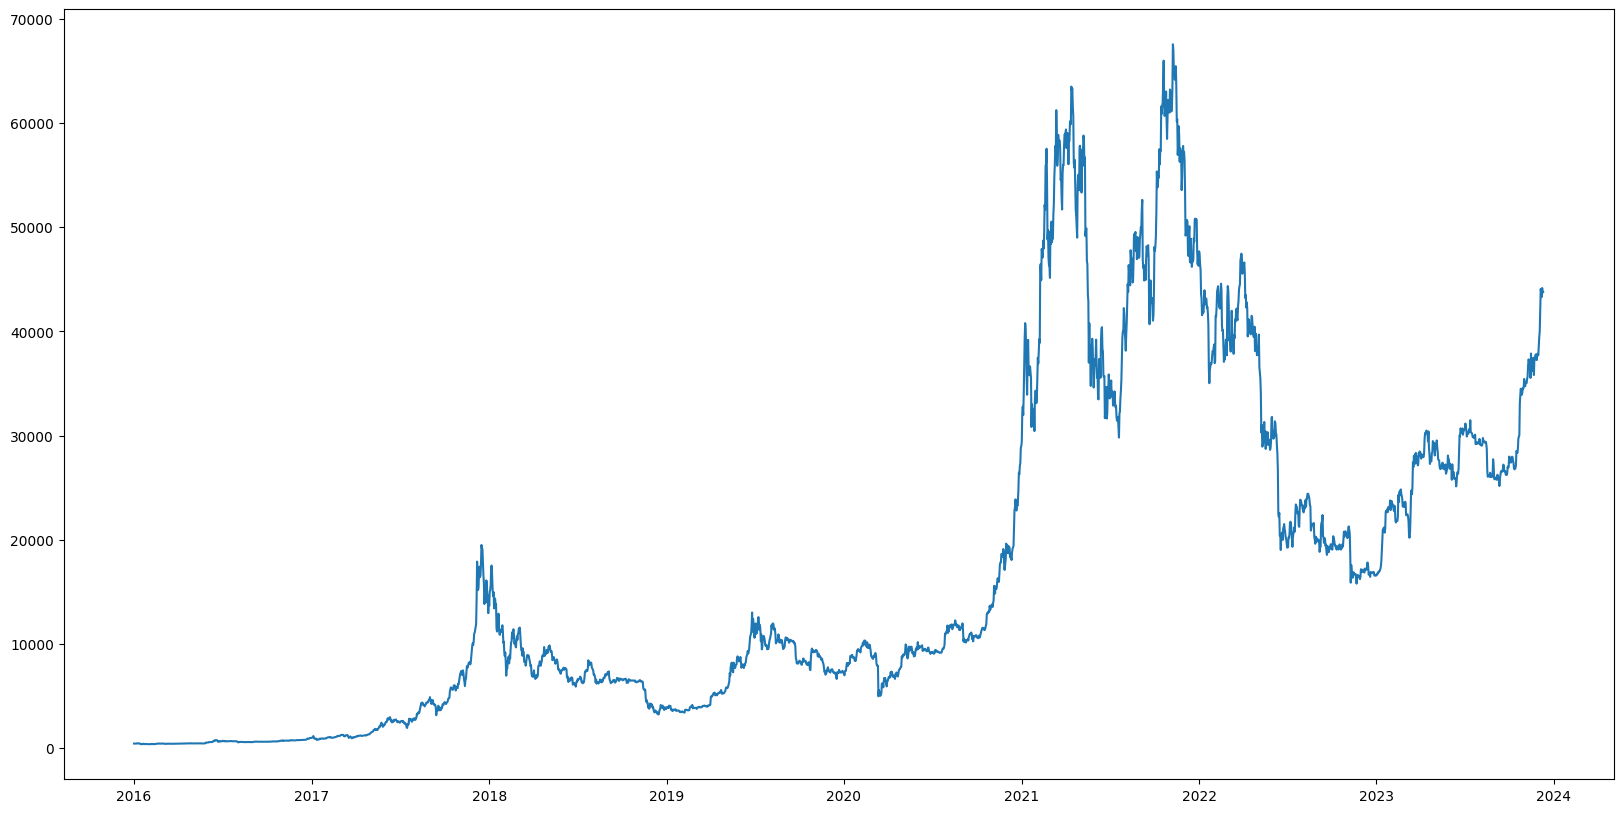

In [7]:
#BTC plot
plt.plot(df['Close'])

In [12]:
#Copy of df with only necessary columns for evaluation
btc = df['Close']
btc.head()

Date
2016-01-01    434.334015
2016-01-02    433.437988
2016-01-03    430.010986
2016-01-04    433.091003
2016-01-05    431.959991
Name: Close, dtype: float64

In [23]:
#Instantiate scaler and turn btc to numpy array
scaler = MinMaxScaler(feature_range = (0,1))
btc = btc.reshape(-1,1)

#Scale data
btc = scaler.fit_transform(btc)

#Train and test data
train = btc[:-100]
test = btc[-100:]

#New dataframe with scaled btc values
new_dataset = pd.DataFrame(index=range(0, len(btc)), columns=['Date', 'Close'])
new_dataset["Date"] = pd.date_range(start="2016-01-01", periods=len(btc))
new_dataset["Close"] = btc
# Set the index to 'Date'
new_dataset.index = new_dataset["Date"]
# Drop the 'Date' column
new_dataset.drop("Date", axis=1, inplace=True)

# Prepare data for LSTM model
x_train_data, y_train_data = [], []
for i in range(60, len(train)):
    x_train_data.append(train[i - 60:i, 0])
    y_train_data.append(train[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [24]:
# Instantiate LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

2741/2741 - 28s - loss: 0.0016 - 28s/epoch - 10ms/step


In [26]:
# Prepare test data
inputs_data = test
inputs_data = scaler.transform(inputs_data)
x_test_data, y_test_data = [], []

for i in range(60, len(inputs_data)):
    x_test_data.append(inputs_data[i - 60:i, 0])
    y_test_data.append(inputs_data[i, 0])

x_test_data, y_test_data = np.array(x_test_data), np.array(y_test_data)
x_test_data = np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1], 1))


In [27]:
# Predictions
predictions = lstm_model.predict(x_test_data)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 2s 13ms/step


In [28]:
mse = np.mean(np.square(test[60:] - predictions))
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0006861329522083682


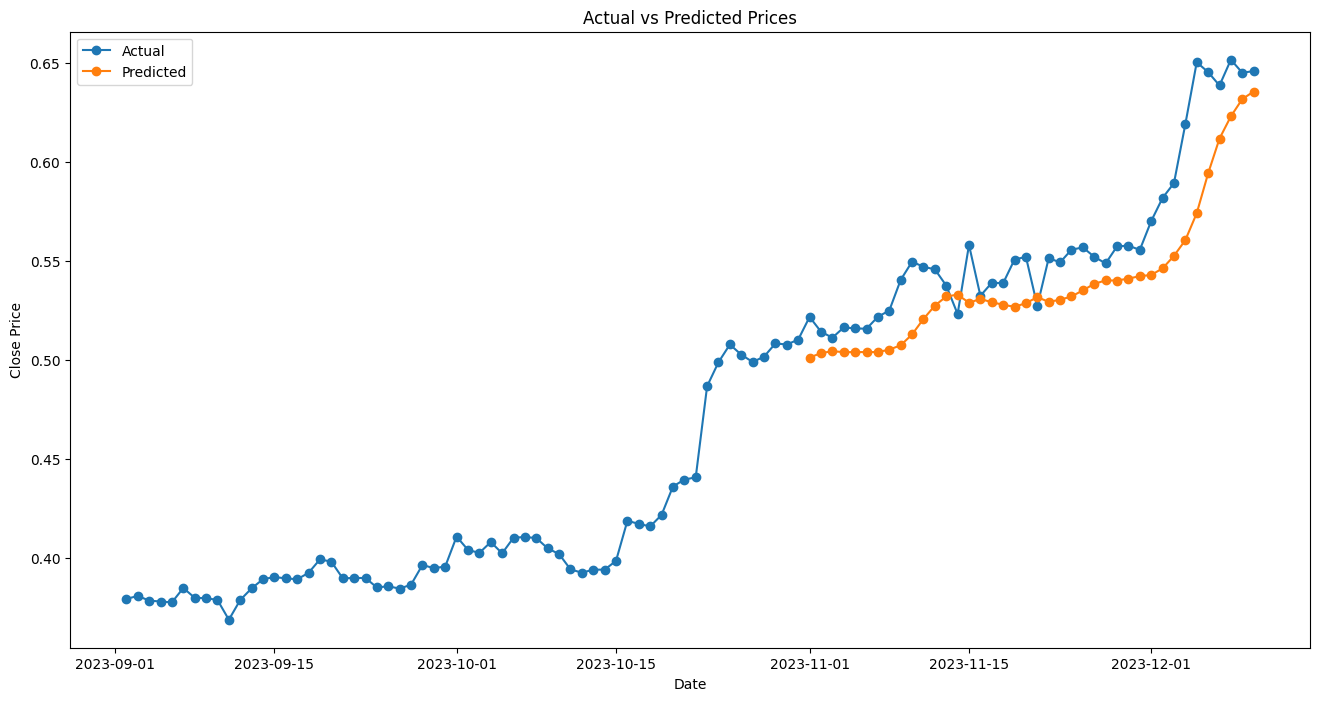

In [35]:
# Create a DataFrame for predictions with corresponding dates
predicted_data = pd.DataFrame(index=new_dataset.index[-100:], columns=['Close'])
predicted_data['Close'] = np.nan  # Initialize with NaN values

# Assign predicted values to the corresponding rows
predicted_data.iloc[-len(predictions):, 0] = predictions.flatten()

plt.figure(figsize=(16, 8))

# Plot actual values
plt.plot(new_dataset.index[-100:], test[-100:], label='Actual', marker='o')

# Plot predicted values
plt.plot(predicted_data.index, predicted_data['Close'], label='Predicted', marker='o')


plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Prices')

plt.legend()
plt.show()